In [ ]:
!pip install -q timm matplotlib seaborn scikit-learn tqdm opencv-python-headless torchinfo

In [ ]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import timm


# set deterministic seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [ ]:
from google.colab import files
uploaded = files.upload()   # upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API is set.")


Saving kaggle.json to kaggle.json
Kaggle API is set.


In [ ]:

# Download the dataset
!kaggle datasets download -d sainatarajan7/mura-dataset --force

# Unzip the first level
!unzip -o -q mura-dataset.zip

# Check if the nested file exists
import os

if os.path.exists("dataset.zip"):
    print("Found nested dataset.zip — extracting...")
    !unzip -o -q dataset.zip
else:
    print("dataset.zip not found — listing contents:")
    !ls -R .

print("Extraction completed.")


Dataset URL: https://www.kaggle.com/datasets/sainatarajan7/mura-dataset
License(s): unknown
 94% 1.28G/1.37G [00:11<00:02, 40.9MB/s]
100% 1.37G/1.37G [00:11<00:00, 122MB/s] 
dataset.zip not found — listing contents:
.:
dataset  kaggle.json  mura-dataset.zip	sample_data

./dataset:
train  valid

./dataset/train:
XR_ELBOW  XR_FINGER  XR_FOREARM  XR_HAND  XR_HUMERUS  XR_SHOULDER  XR_WRIST

./dataset/train/XR_ELBOW:
0.png	  1249.png  1498.png  1746.png	1995.png  261.png  50.png   759.png
1000.png  124.png   1499.png  1747.png	1996.png  262.png  510.png  75.png
1001.png  1250.png  149.png   1748.png	1997.png  263.png  511.png  760.png
1002.png  1251.png  14.png    1749.png	1998.png  264.png  512.png  761.png
1003.png  1252.png  1500.png  174.png	1999.png  265.png  513.png  762.png
1004.png  1253.png  1501.png  1750.png	199.png   266.png  514.png  763.png
1005.png  1254.png  1502.png  1751.png	19.png	  267.png  515.png  764.png
1006.png  1255.png  1503.png  1752.png	1.png	  268.png  516.png 

In [5]:
from pathlib import Path
import os

# Root of the TRAIN dataset (same structure as TensorFlow version)
TRAIN_PATH = "/content/dataset/train"

data_root = Path(TRAIN_PATH)

# Validate path exists
if not data_root.exists():
    raise Exception(f"TRAIN folder not found at {TRAIN_PATH}. Check extraction.")

print("Dataset root:", data_root)

# List body part folders (XR_ELBOW, XR_WRIST, etc.)
body_dirs = sorted([d for d in data_root.iterdir() if d.is_dir()])
print("Body part dirs:", [d.name for d in body_dirs])


Dataset root: /content/dataset/train
Body part dirs: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


In [6]:
import pandas as pd
from pathlib import Path

rows = []

# Loop through each body-part folder discovered in CELL 1
for body in body_dirs:
    image_files = sorted(list(body.glob("*.png")))   # all MURA images

    for img in image_files:
        rows.append({
            "body": body.name,           # class label
            "study_path": str(img),      # path to this image
            "image_paths": [str(img)],   # list (MURA original has multiple imgs, here single)
        })

df = pd.DataFrame(rows)

print("Total images:", len(df))
df.head()

Total images: 15407


,body,study_path,image_paths
0,XR_ELBOW,/content/dataset/train/XR_ELBOW/0.png,[/content/dataset/train/XR_ELBOW/0.png]
1,XR_ELBOW,/content/dataset/train/XR_ELBOW/1.png,[/content/dataset/train/XR_ELBOW/1.png]
2,XR_ELBOW,/content/dataset/train/XR_ELBOW/10.png,[/content/dataset/train/XR_ELBOW/10.png]
3,XR_ELBOW,/content/dataset/train/XR_ELBOW/100.png,[/content/dataset/train/XR_ELBOW/100.png]
4,XR_ELBOW,/content/dataset/train/XR_ELBOW/1000.png,[/content/dataset/train/XR_ELBOW/1000.png]


In [7]:
import pandas as pd

rows = []

# Use data_root (defined in CELL 1)
for body_dir in sorted([d for d in data_root.iterdir() if d.is_dir()]):
    for img_path in sorted(body_dir.glob('*.png')):
        rows.append({
            'body': body_dir.name,
            'image_path': str(img_path)
        })

df = pd.DataFrame(rows)

print("Total samples:", len(df))
print(df["body"].value_counts())

# class names sorted alphabetically
body_classes = sorted(df["body"].unique())
print("Classes:", body_classes)

# mapping class ↔ index
class2idx = {c: i for i, c in enumerate(body_classes)}
idx2class = {i: c for c, i in class2idx.items()}

df["label"] = df["body"].map(class2idx)

df.head()

Total samples: 15407
body
XR_ELBOW       2201
XR_FINGER      2201
XR_FOREARM     2201
XR_HAND        2201
XR_HUMERUS     2201
XR_SHOULDER    2201
XR_WRIST       2201
Name: count, dtype: int64
Classes: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


,body,image_path,label
0,XR_ELBOW,/content/dataset/train/XR_ELBOW/0.png,0
1,XR_ELBOW,/content/dataset/train/XR_ELBOW/1.png,0
2,XR_ELBOW,/content/dataset/train/XR_ELBOW/10.png,0
3,XR_ELBOW,/content/dataset/train/XR_ELBOW/100.png,0
4,XR_ELBOW,/content/dataset/train/XR_ELBOW/1000.png,0


In [8]:
# CELL 5 — stratified splits
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print("Sizes -> Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Sizes -> Train: 12325 Val: 1541 Test: 1541


In [9]:
# CELL 6 — transforms & dataset
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class MURADataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label

train_ds = MURADataset(train_df, transform=train_transform)
val_ds = MURADataset(val_df, transform=val_transform)
test_ds = MURADataset(test_df, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [10]:
# =====================================
# CELL 7 — Build DenseNet121 Model
# =====================================

import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary # Import summary function

num_classes = len(body_classes)
print("Num classes:", num_classes)

# Load pretrained DenseNet121
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Freeze backbone for Phase-1 (same as TensorFlow base.trainable = False)
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

model = model.to(device)

# Loss, Optimizer, LR Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# For mixed-precision
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


print("\nMODEL SUMMARY (like TensorFlow model.summary()):\n")
summary(model,
        input_size=(1, 3, IMG_SIZE, IMG_SIZE),
        depth=3,              # how deep to expand internal modules
        col_names=["input_size", "output_size", "num_params"])


Num classes: 7
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 35.2MB/s]
/tmp/ipython-input-770106438.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None



MODEL SUMMARY (like TensorFlow model.summary()):



Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DenseNet                                 [1, 3, 224, 224]          [1, 7]                    --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                         [1, 64, 112, 112]         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 64, 56, 56]           [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 64, 56, 56]           [1, 32, 56, 56]           (45,440)
│    │    └─_DenseLayer: 3-2             [1, 64, 56, 56]           [1, 32, 56, 56]           (49,600)
│    │    └─_De

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Define the device (already defined as 'device' in zxZSF-yIQxCC, but using DEVICE here for consistency with the original error's intent)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            probabilities = torch.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy, np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

# ===========================================
# CELL 9 — Training Loop (Equivalent to TF)
# ===========================================

EPOCHS_1 = 6

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(EPOCHS_1):
    print(f"\n----- Epoch {epoch+1}/{EPOCHS_1} -----")

    # Training
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device, scaler
    )

    # Validation
    val_loss, val_acc, y_true_val, y_pred_val, val_probs = eval_model(
        model, val_loader, criterion, device
    )

    # LR scheduler update
    scheduler.step(val_loss)

    # Save into history dict (similar to TF history.history)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")



----- Epoch 1/6 -----


Training:   0%|          | 0/386 [00:00<?, ?it/s]/tmp/ipython-input-4029068623.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 49/49 [00:09<00:00,  5.11it/s]


Train Loss: 1.0955 | Train Acc: 0.6859
Val   Loss: 0.6327 | Val   Acc: 0.8404

----- Epoch 2/6 -----


Validation: 100%|██████████| 49/49 [00:09<00:00,  4.96it/s]


Train Loss: 0.5596 | Train Acc: 0.8365
Val   Loss: 0.4424 | Val   Acc: 0.8838

----- Epoch 3/6 -----


Validation: 100%|██████████| 49/49 [00:09<00:00,  5.01it/s]


Train Loss: 0.4463 | Train Acc: 0.8616
Val   Loss: 0.3654 | Val   Acc: 0.8890

----- Epoch 4/6 -----


Validation: 100%|██████████| 49/49 [00:08<00:00,  5.52it/s]


Train Loss: 0.3860 | Train Acc: 0.8762
Val   Loss: 0.3311 | Val   Acc: 0.9053

----- Epoch 5/6 -----


Validation: 100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


Train Loss: 0.3599 | Train Acc: 0.8852
Val   Loss: 0.3060 | Val   Acc: 0.9098

----- Epoch 6/6 -----


Validation: 100%|██████████| 49/49 [00:09<00:00,  5.28it/s]

Train Loss: 0.3437 | Train Acc: 0.8901
Val   Loss: 0.2922 | Val   Acc: 0.9143


In [13]:
# CELL 9 — training loop
EPOCHS = 10
best_val_acc = 0.0
patience = 5
wait = 0
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch+1}/{EPOCHS} ---')
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
    val_loss, val_acc, _, _, _ = eval_model(model, val_loader, criterion, device)
    print(f'Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f}')

    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'mura_bodypart_model.pth')
        print('Saved best model -> mura_bodypart_model.pth')
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping triggered.')
            break




--- Epoch 1/10 ---


Training:   0%|          | 0/386 [00:00<?, ?it/s]/tmp/ipython-input-4029068623.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 49/49 [00:08<00:00,  5.52it/s]


Train loss: 0.3262 acc: 0.8932 | Val loss: 0.2751 acc: 0.9163
Saved best model -> mura_bodypart_model.pth
--- Epoch 2/10 ---


Validation: 100%|██████████| 49/49 [00:09<00:00,  4.99it/s]


Train loss: 0.3157 acc: 0.8991 | Val loss: 0.2709 acc: 0.9169
Saved best model -> mura_bodypart_model.pth
--- Epoch 3/10 ---


Validation: 100%|██████████| 49/49 [00:09<00:00,  5.36it/s]


Train loss: 0.3062 acc: 0.9025 | Val loss: 0.2728 acc: 0.9150
--- Epoch 4/10 ---


Validation: 100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


Train loss: 0.3014 acc: 0.9030 | Val loss: 0.2796 acc: 0.9091
--- Epoch 5/10 ---


Validation: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


Train loss: 0.2886 acc: 0.9066 | Val loss: 0.2706 acc: 0.9143
--- Epoch 6/10 ---


Validation: 100%|██████████| 49/49 [00:08<00:00,  5.45it/s]


Train loss: 0.2847 acc: 0.9048 | Val loss: 0.2568 acc: 0.9150
--- Epoch 7/10 ---


Validation: 100%|██████████| 49/49 [00:09<00:00,  4.91it/s]

Train loss: 0.2801 acc: 0.9092 | Val loss: 0.2621 acc: 0.9111
Early stopping triggered.


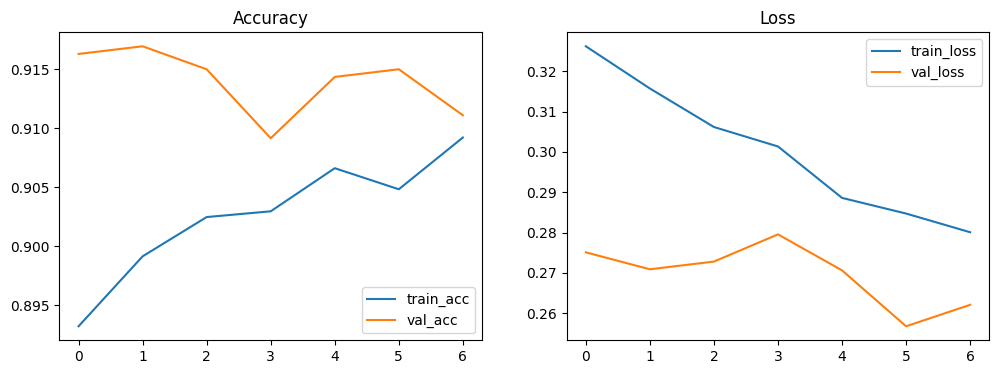

In [14]:
# plot training curves and save
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Validation: 100%|██████████| 49/49 [00:11<00:00,  4.13it/s]


Test Accuracy: 0.9169


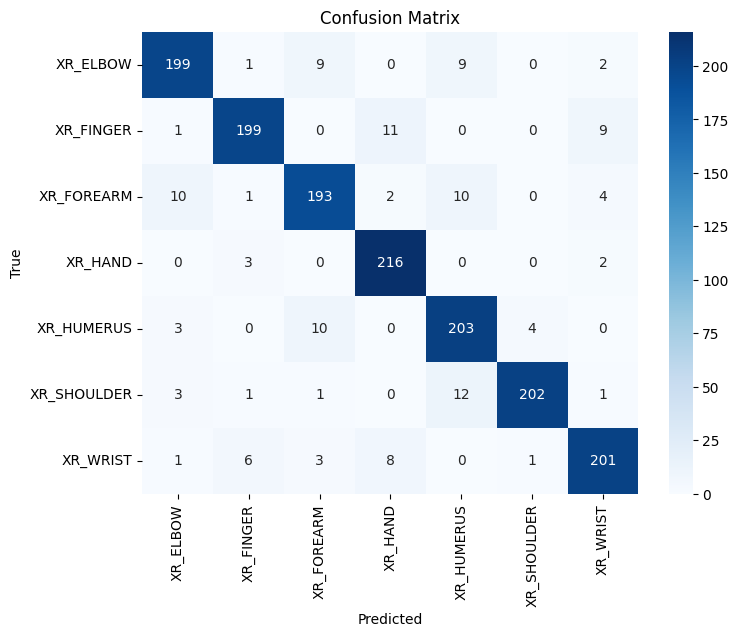

              precision    recall  f1-score   support

    XR_ELBOW       0.92      0.90      0.91       220
   XR_FINGER       0.94      0.90      0.92       220
  XR_FOREARM       0.89      0.88      0.89       220
     XR_HAND       0.91      0.98      0.94       221
  XR_HUMERUS       0.87      0.92      0.89       220
 XR_SHOULDER       0.98      0.92      0.95       220
    XR_WRIST       0.92      0.91      0.92       220

    accuracy                           0.92      1541
   macro avg       0.92      0.92      0.92      1541
weighted avg       0.92      0.92      0.92      1541



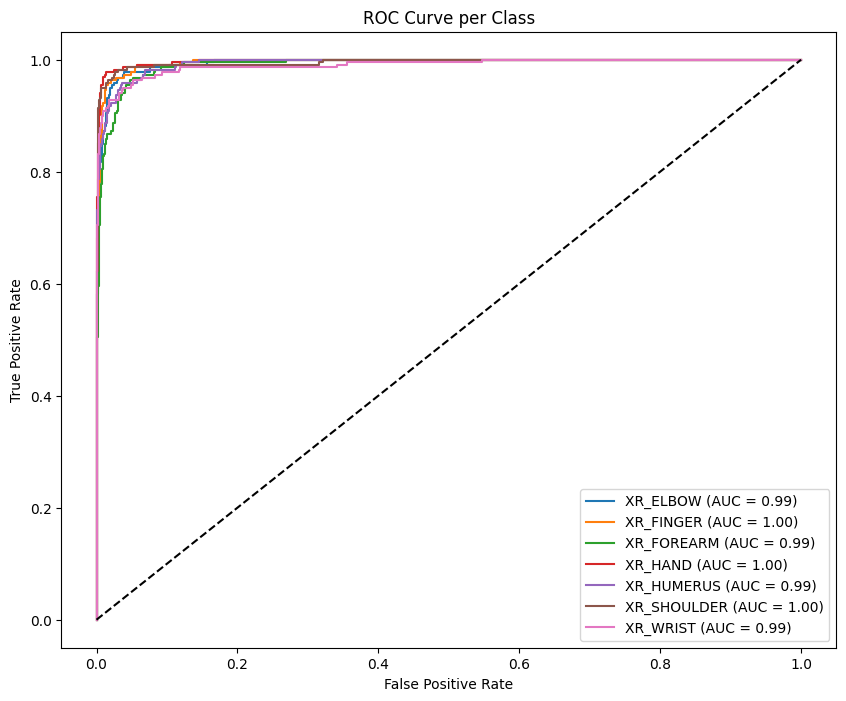

Saved test_predictions.npz


In [15]:
# ============================================
# CELL 10 — Full Evaluation & Visualization
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import torch

# Load best saved model
model.load_state_dict(torch.load("mura_bodypart_model.pth", map_location=device))
model.to(device)

# ---- Evaluate on Test Set ----
test_loss, test_acc, y_true, y_pred, y_prob = eval_model(
    model, test_loader, criterion, device
)

print(f"Test Accuracy: {test_acc:.4f}")

# ============================================
# CONFUSION MATRIX
# ============================================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=body_classes,
    yticklabels=body_classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=body_classes, zero_division=0))

# ============================================
# ROC CURVES (per class)
# ============================================

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{body_classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend()
plt.savefig("roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# SAVE PREDICTIONS
# ============================================

np.savez_compressed(
    "test_predictions.npz",
    y_true=np.array(y_true),
    y_pred=np.array(y_pred),
    y_prob=np.array(y_prob)
)

print("Saved test_predictions.npz")


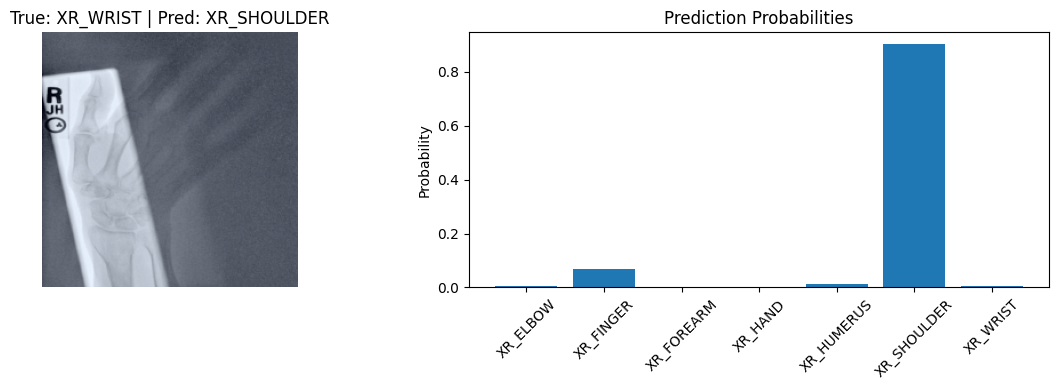

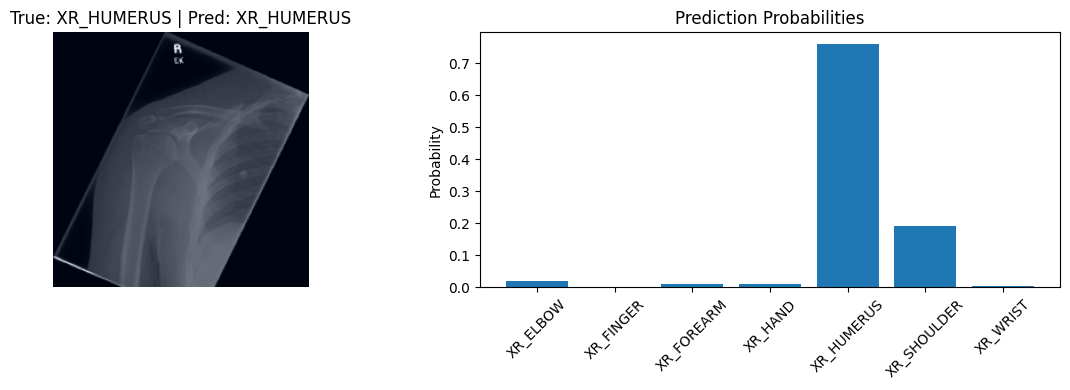

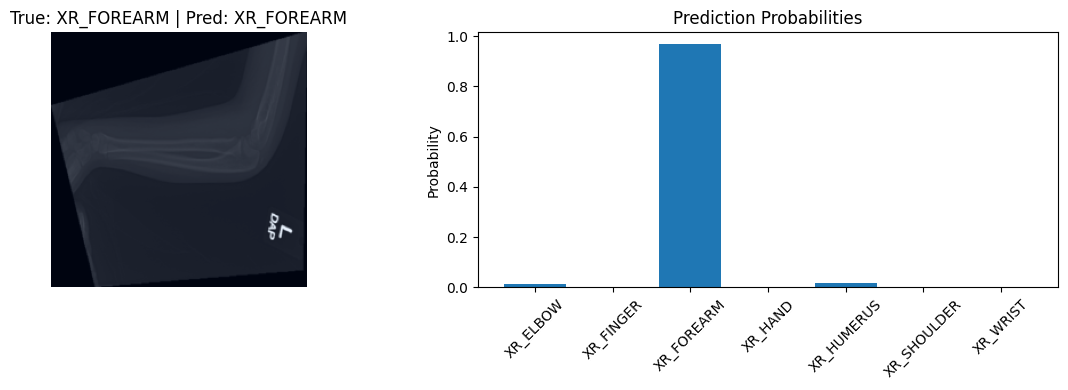

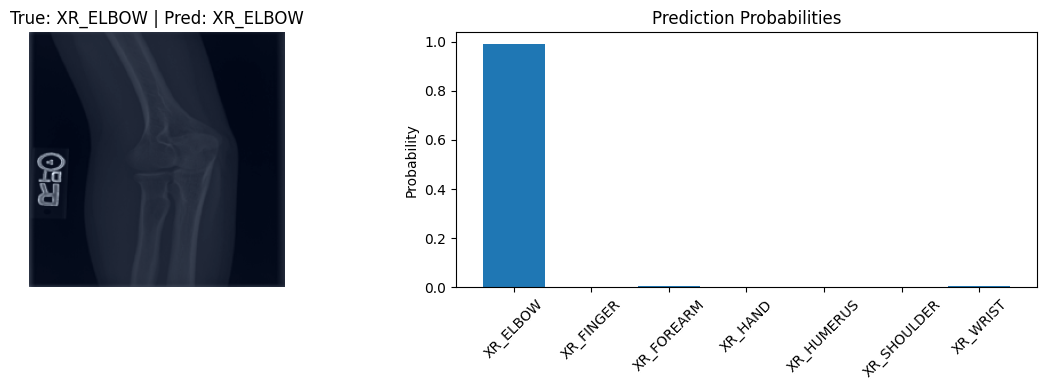

In [17]:
# =======================================================
# CELL — Show Predictions + Probability Bars (PyTorch)
# =======================================================

import matplotlib.pyplot as plt
import numpy as np

# Take one batch from test_loader
xb, yb = next(iter(test_loader))

xb = xb.to(device)
yb = yb.to(device)

# Evaluate
model.eval()

with torch.no_grad():
    logits = model(xb)
    probs = torch.softmax(logits, dim=1)

# Convert to CPU numpy
xb = xb.cpu().numpy()
yb = yb.cpu().numpy()
probs = probs.cpu().numpy()

# Show first 4 samples
for i in range(min(4, xb.shape[0])):
    img = np.transpose(xb[i], (1, 2, 0))  # CHW -> HWC
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display

    pred_idx = np.argmax(probs[i])
    true_name = body_classes[int(yb[i])]
    pred_name = body_classes[pred_idx]

    plt.figure(figsize=(12,4))

    # Image with labels
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"True: {true_name} | Pred: {pred_name}")
    plt.axis("off")

    # Probability bar graph
    plt.subplot(1,2,2)
    plt.bar(body_classes, probs[i])
    plt.ylabel("Probability")
    plt.xticks(rotation=45)
    plt.title("Prediction Probabilities")

    plt.tight_layout()
    plt.show()
